In [29]:
import numpy as np
import scipy as sp
import sys
import random
import functools


import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

from sklearn.datasets import make_blobs
from sklearn import preprocessing

In [35]:
X_raw = make_blobs(n_samples=2000, n_features=2, centers = [[-5,-5], [-1,2], [7,4], [5, -5]], random_state=0)[0]
X = preprocessing.scale(X_raw)

In [32]:
#-------------------------------------------------------------------------------------------------------------------------------------
#initialize means
def initialize_centroids(X, cluster_num):
    minmaxranges = []
    for col in X.T:
        minmaxcolrange = [np.min(col), np.max(col)]
        minmaxranges.append(minmaxcolrange)
    
    #this generates a vector within the min/max bounds of each dimension in the dataset
    initcentroids = np.array([ np.array([random.uniform(componentrange[0], componentrange[1]) for componentrange in minmaxranges]) for i in range(cluster_num) ])
    
    return initcentroids
#--------------------------------------------------------------------------------------------------------------------------------------
#cluster_posterior is our q-distribution over which we take the expectation of the joint distribution on x and its cluster assignment

def cluster_posterior(x, pi, clust_means, clust_covars):
    
    clusternums = len(pi)
    norm = sum([ pi[j] * multivariate_normal.pdf(x, mean = clust_means[j], cov = clust_covars[j] ) for j in range(clusternums)])
    
    if norm == 0.0: #avoids a singularity condition when denominator is small
        return (1/clusternums)*np.ones(clusternums)
    else:
        posterior = np.array([(1/norm) * pi[k] * multivariate_normal.pdf(x, mean = clust_means[k], cov = clust_covars[k] ) for k in range(clusternums) ])
        
    return posterior


#---------------------------------------------------------------------------------------------------------------------------------------
# calculate new parameters for gaussian mixture
def MStep(X, qdist, clustermeans):
    #qdist is N by clustnum weight matrix
    
    N = np.shape(X)[0] # total number of observations
    cluster_num = np.shape(qdist)[1]
    
    n_distrib = np.array( [sum(qdist[:, k]) for k in range(cluster_num) ] ) # weighted number of observations in each cluster
    Pi = (1/N)*n_distrib #new Pi distribution
    #print(Pi)
    #generates new centroids -- expression takes n-length weight for being in kth cluster for each observation and dots it with data matrix
    #generates weighted sum of observations for kth cluster -- does this for all clusters and spits out clustnum by feature_dim centroid matrix
    
    centroids = np.array([ (1/n_distrib[k])*np.dot(qdist[:,k], X) for k in range(cluster_num) ]) 
    
    # use new centroids to create updated covariance matrices
    sigmalist = []
    for k in range(cluster_num):
            sigmak = (1/n_distrib[k]) * sum( [ qdist[i, k]*np.outer( (X[i] - centroids[k]), (X[i] - centroids[k])) for i in range(N)])
            sigmalist.append(sigmak)
    
    sigma = np.array(sigmalist)
    
    
    return Pi, centroids, sigma


#---------------------------------------------------------------------------------------------------------------------------------------
#define EM-GMM

def EM_GMM(X, clusternum, iternums):
    
    # initialization
    n = np.shape(X)[0] # number of observations
    d = np.shape(X)[1] # feature dimensionality
    
    Pi = (1/clusternum) * np.ones(clusternum) 
    clustmeans = initialize_centroids(X, clusternum ) #initialize means
    
    data_avg = np.average(X, axis = 0) 
    centered_data = X - data_avg
    Xcovar = (1/n)*np.dot( centered_data.T, centered_data)
    
    sigmas = np.array([Xcovar for k in range(clusternum)]) # numpy array of covariance matrices 
    #sigmas = np.array([.2*np.identity(d) for k in range(clusternum)]) # numpy array of covariance matrices 
    
    for i in range(iternums):
        
        # evaluate q distribution at current step
        
        parfunc = functools.partial(cluster_posterior, pi = Pi, clust_means = clustmeans, clust_covars = sigmas)
        qdist = np.array(list(map(parfunc, X))) # n x clustnum numpy array
        Pi, clustmeans, sigmas = MStep(X, qdist, clustmeans)
        
        
        filename = "pi-" + str(i+1) + ".csv" 
        np.savetxt(filename, Pi, delimiter=",") 
        filename = "mu-" + str(i+1) + ".csv"
        np.savetxt(filename, clustmeans, delimiter=",")
        
        for j in range(clusternum): #k is the number of clusters 
            filename = "Sigma-" + str(j+1) + "-" + str(i+1) + ".csv" #this must be done 5 times (or the number of clusters) for each iteration
            np.savetxt(filename, sigmas[j], delimiter=",")
                
    return clustmeans

In [36]:
q = EM_GMM(X, 4, 20)

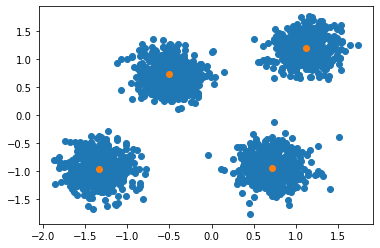

In [37]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(q[:,0], q[:,1])